# Section 8: Maps of Individual Patches and Harmonic Analysis using CAR maps

Now that users are able to import and examine data we present an introduction to harmonic analysis using the DR4 maps.  We will present an example of a simple ACT-Planck cross correlation as well as an example using the splits from a single patch.  We also encourage users to consider cross correlations with other maps or galaxy density maps.

We ask that when using the map splits used in this notebook you reference [Aiola et al. 2020, in preparation] .

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to ACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps from [Naess et al. (2020)](https://www.overleaf.com/5395816498bsknshgxbmyr) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020, in preparation]

> [Section 7](Section_7_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al. (2020)](https://arxiv.org/abs/1911.05717)

> [Section 8](Section_8_individual_maps_and_harmonic_analysis.ipynb): Maps of Individual Patches and Harmonic Analysis using CAR maps [Aiola et al, in preparation]

> [Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 10](Section_10_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 11](Section_11_ACT_likelihood.ipynb): Using the ACT Likelihood code
 
---


## Initialize notebook

For this notebook we need tools from the first notebook as well as from the [coadded_maps notebook](Section_2_coadded_maps.ipynb) which reads in the ACT map, and then the [HEALPix_CAR_Conversions notebook](HEALPix_CAR_Conversions.ipynb) which reads in a planck map and converts it from HEALPix format to the CAR format used for ACT maps.

Since the 3rd notebook runs the other two we just run the 3rd one here.  It's worth noting that the 3rd notebook uses the coadded maps which are large data files.  As described in the notebook 2 there are two ways to handle these larger files, users can choose to import the lower resolution map or the full resolution map depending on their computer's capabilities.  The 3rd notebook will default to the down graded map so you will need to edit that if you wish to use the full resolution map instead.

These commands output the maps produced in the other notebooks so if you would like to see a more in-depth explanation of how these maps are formed feel free to navigate to those notebooks by using the links above.


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


//anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


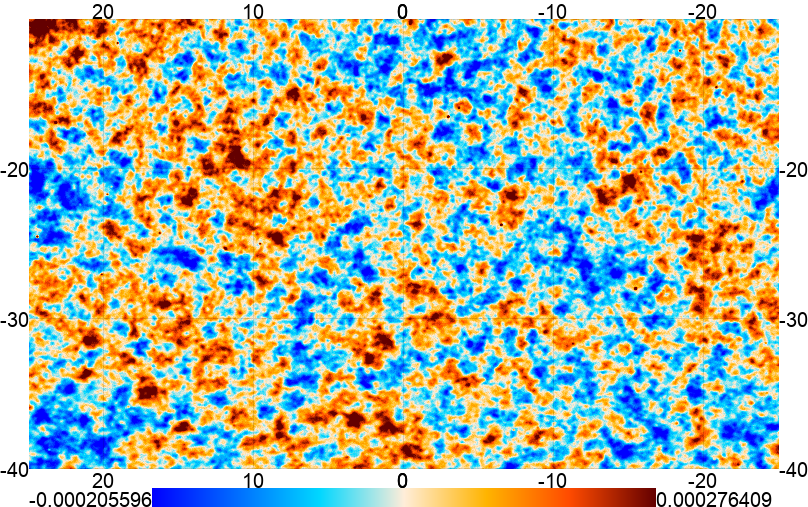

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [1]:
%run Section_3_HEALPix_CAR_Conversions.ipynb

# Section 1: Harmonic analysis using CAR maps (Planck x ACT example)

## Method 1:  Fourier transforms using Enmap

We will begin by trimming both ACT and Planck maps to the same size, and then we use enmap's functions to Fourier transform the map using the 'flat-sky' approximation.  

Before Fourier transforming the maps it is necessary to apodize the edges of the maps so that periodic boundary conditions apply.  This can easily be done using the enmap library of functions. The taper can be adjusted by changing the 'apod_pix' variable which adjusts the number of pixels that are apodized.

Here we chose to use only the I maps, however, the Q and U maps can of course be tapered in the same manner if desired.

Apodization


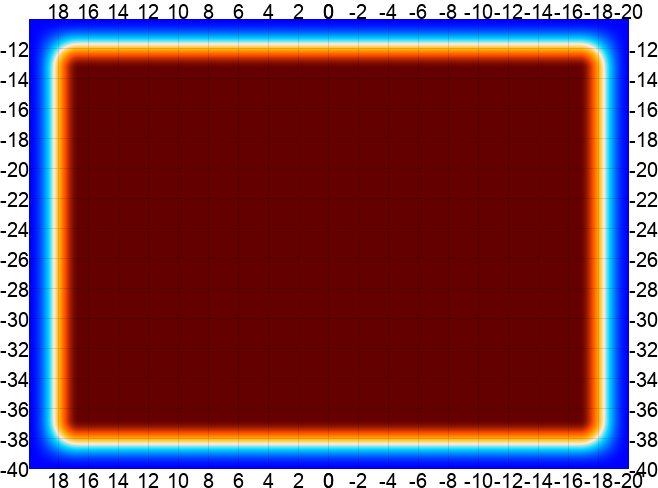

Apodized ACT map


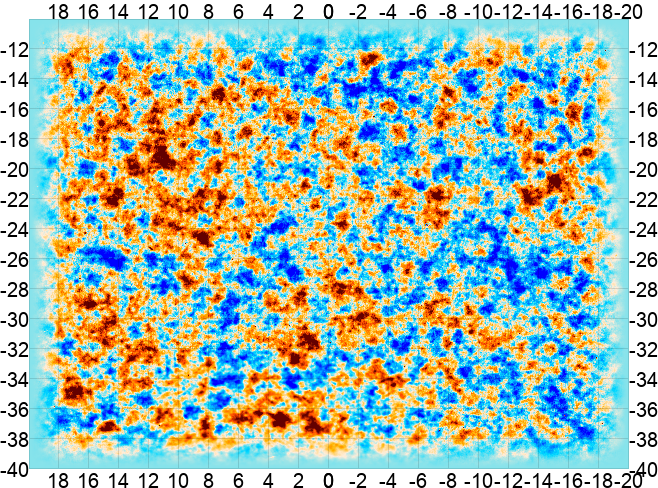

Apodized Plank map


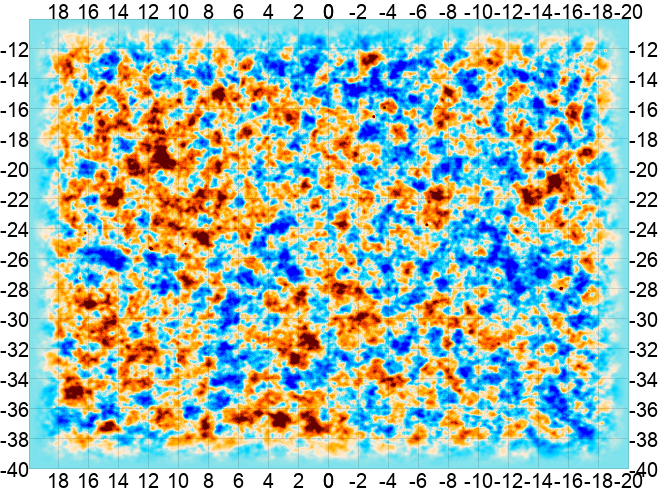

In [6]:
# Trim Maps
box = np.array([[-40,20],[-10,-20]])*utils.degree
smap_act    = imap.submap(box)
smap_planck = planck_map.submap(box)

# Define taper using enmap.apod and then plot the taper
apod_pix = 100
taper    = enmap.apod(smap_act*0+1,apod_pix) #Ensures the taper map has the same shape and wcs as the data
print("Apodization")
eshow(taper,  **{"downgrade": 2, "ticks": 2})

# Apply taper to the two maps by multiplying the taper and maps together
print("Apodized ACT map")
eshow(taper*smap_act, **{"downgrade": 2,  "ticks": 2})

print("Apodized Plank map")
eshow(taper*smap_planck[0], **{"downgrade": 2,  "ticks": 2})

Now that we have the apodized maps we can begin the harmonic analysis.  

Step one is to use enmap to get a Fourier transformation of the map.  For ease of use we set the normalization of the Fourier transformation to physical by passing the 'phys' parameter.  This makes Pixell take into account pixel area factors when calculating the power, and results in power spectra with steradians as the unit of area.

Once you have the Fourier transformed map it is possible to make a naive power spectra by multiplying by the transform conjugate and then binning the spectra.

One thing we note is that Pixell has a function that lets you call the 'modlmap' of a ndmap.  This is a map that gives the distance in Fourier space of each pixel to the center of the map.  It's particularly useful for binning the power spectra and we will use it in the binning function below.

In [7]:
# Fourier transform the map:
kmap_act = enmap.fft(smap_act*taper, normalize = 'phys')
kmap_planck = enmap.fft(smap_planck[0]*taper*1e6, normalize = 'phys')

# Get cross power
cross_power = abs(kmap_act*np.conj(kmap_planck))

# Define a function that can bin the power by Fourier component magnitude
# This is the flat sky equivalent of "ell"
def bin(data, imap, lmax, bin_size):
    modlmap = imap.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    binned = np.bincount(digitized, data.reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return centers, binned

# The Taper we applied earlier effects the power spectrum. 
# Pixell doesn't have the capability to fully account for the taper
# But we can get an approximate correction by dividing out the following term
w2 = np.mean(taper**2)

ell_b, binned_cross_power = bin(cross_power/w2, smap_act, lmax = 6000, bin_size = 40)

Now that we've binned the power spectrum we made we can plot it quickly to have a look at it.

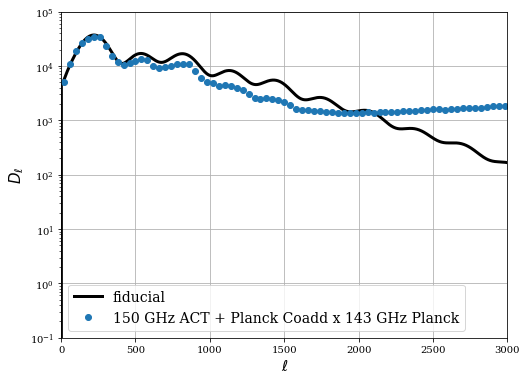

In [8]:
# Read in a camb fiducial spectrum for comparison
from pixell import powspec
camb_theory = powspec.read_spectrum(path + "camb_theory.dat")
cltt = camb_theory[0,0,:3000]
ls = np.arange(cltt.size)

# Now plot the quick powerspectrum we just made
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ls, cltt*ls**2., lw=3, color='k', label = "fiducial")
plt.plot(ell_b, ell_b**2*binned_cross_power, marker="o", ls="none",
         label = "150 GHz ACT + Planck Coadd x 143 GHz Planck")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.xlim(0, 3000)
plt.ylim(.1, 1e5)
plt.grid(True)
plt.legend(fontsize = 14)
plt.show()

We see two prominent features in this cross-spectrum: for intermediate $l$, there is some "missing" cross-power with respect to the fiducial curve. At high $l$, the data has a rising cross-power "tail," while the fiducial spectrum continues to fall off.

Generally speaking, the former feature is due to a combination of the damping effect of the various transfer functions in the experiments (e.g. Planck's wider beam), which we haven't accounted for. The latter captures the contribution from small-scale features in the maps, such as point sources and high-frequency noise. 

As a quick demonstration of the difference in the two experiments, we can plot the ACT-only power spectrum (i.e. the ACT autospectrum).

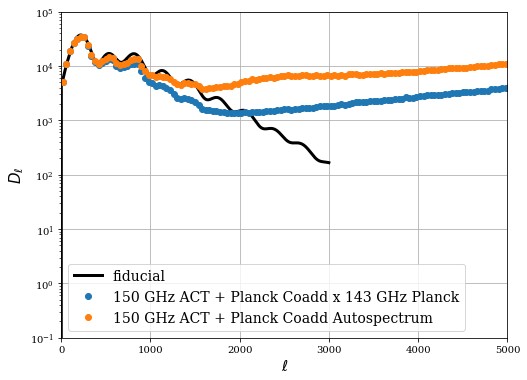

In [9]:
# Get ACT power
auto_power = abs(kmap_act*np.conj(kmap_act))

ell_b, binned_auto_power = bin(auto_power/w2, smap_act, lmax = 6000, bin_size = 40)

# Plot the ACT autospectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ls, cltt*ls**2., lw=3, color='k', label = "fiducial")
plt.plot(ell_b, ell_b**2*binned_cross_power, marker="o", ls="none",
         label = "150 GHz ACT + Planck Coadd x 143 GHz Planck")
plt.plot(ell_b, ell_b**2*binned_auto_power, marker="o", ls="none",
         label = "150 GHz ACT + Planck Coadd Autospectrum")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.xlim(0, 5000)
plt.ylim(.1, 1e5)
plt.grid(True)
plt.legend(fontsize = 14)
plt.show()

As expected, we recover some of the intermediate $l$ power. On the other hand, we lose the benefit of having uncorrelated (really, less-correlated) noise between the two maps, so the power of the high $l$ tail has increased.

## Method 2: Spherical harmonics using Pixell

We turn now to Pixell's curvedsky functions that enable spherical harmonic analysis of the patches.  The process is very similar to what one would do using the HEALPix library.  We will get alms from the maps; from there we get the cls from the alms. 

Again we want to weight our power spectrum by an area correction factor as well as the taper we've applied.

In [10]:
from pixell import curvedsky 

# First we get the alms
alms_act = np.cdouble(curvedsky.map2alm(smap_act*taper, lmax = 6000))
alms_planck = np.cdouble(curvedsky.map2alm(smap_planck*taper*1e6, lmax = 6000)[0])

# Next step we get the cls using healpy
cls = hp.alm2cl(alms_act, alms_planck)

# We also want the corresponding ells which we can get easily
ell = np.arange(len(cls))

# Now we calculate the weighting we have to apply to our spectrum due to the 
# trimmed size
w2_new = enmap.area(smap_act.shape, smap_act.wcs)/4./np.pi

# Now we combine these to get the Dls
Dl = cls*ell**2 / w2_new 

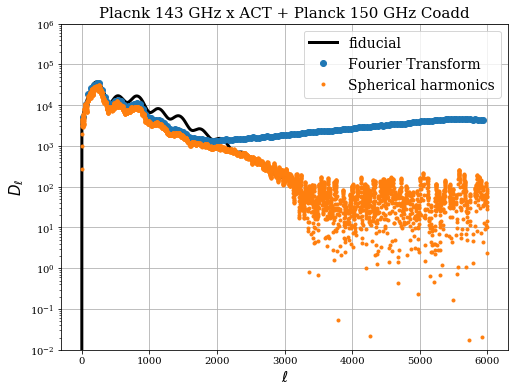

In [11]:
# Now we can plot our power spectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.grid(True)
plt.plot(ls,cltt*ls**2.,lw=3,color='k', label = "fiducial")
plt.plot(ell_b,ell_b**2*binned_cross_power,marker="o",ls="none", label = "Fourier Transform")
plt.plot(ell, Dl, '.', label = "Spherical harmonics")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.title("Placnk 143 GHz x ACT + Planck 150 GHz Coadd", fontsize = 15)
plt.ylim(.01 ,1e6)
plt.legend(fontsize = 14)
plt.show()

In the plot above we can quite clearly see some of the acoustic oscillations as we would expect, and the agreement with the fiducial spectrum has improved versus the flat sky approximation at high $l$. However, there are still a few glaring problems.  Firstly, the spectrum  hasn't been corrected for beams or other pixel transfer functions both of which would need to be done for a true analysis.  This effect is easily noticeable at intermediate $l$ where our power spectra underestimates the fiducial spectrum. Also, we didn't mask point sources which can be done using the correct Planck mask and the source free ACT maps (the spectrum still plateaus at high $l$).

Furthermore we account for the window function using a relatively simple approach, however, to truly decouple it one should use a program such as **Namaster**, **pspy** or **pitas** which explicitly decouple the window functions.

Finally it's important to realize that calculating the error for any cross correlations would need to include knowledge of the noise model which is currently not complete.  

Despite the limitations, quick and useful power spectra can be made relatively easily using this approach and can be done with galaxy density maps or other CMB maps.

# Section 2: Spectra using maps of the individual patches

We now turn the the maps of the indivdual patches that are included in DR4.  These are the maps used to generate the power spectra discussed in Choi et al. (2020).  For this example we will use spherical harmonics but the fourier method demonstrated above could also be applied to these maps.

## Accessing the available map splits

The season 13 through 16 maps cover ~ 17,000 sq degrees on the sky and we present both 98 GHz and 150 GHz maps. They include data used to make the maps presented in Naess et al. (2014) and Louis et al. (2017) along with sumplemental observations from 2015 and 2016. While we will only use the data from the D8 patch in this particular notebook, the rest of the patch, array, season and frequncy combinations are detailed in Table 1 and in [Aiola et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=ACT_DR4_A20_v20200420.pdf)

---
Table 1: Summary of patch sizes and white-noise levels
---



Season | s13|s14|s15|s16
---|---|---|---|---
**Array and Frequency** | **PA1$_{150}$** | **PA1$_{150}$/ PA2$_{150}$**|  **PA1$_{150}$**/ **PA2$_{150}$/PA3$_{98}$ / PA3$_{150}$**| **PA2/PA3$_{98}$/PA3$_{150}$**
**D1 (131 sq deg)**| 18.6 | | |
**D5 (157 sq deg)** | 16.4 
**D6 (135 sq deg)**| 12.6|
**D56 (834 sg deg)**| | 32.3/20.5 | 33.3/21.9/18.4/28.6|
**D8 (248 sq deg)**| | | 42.0/21.5/20.0/29.0|
**BN (3157 sq deg)**| | |76.8/41.3/33.9/49.1
**AA (17044 sq deg)** | | || 72.9/78.7/118.5

White noise levels are given in units of $\mu$K-arcmin.

---

For each of the patch, season, array and frequency combination we include 4 splits (with the exception of patch AA which includes 2) as well as one map-based co-add resulting in 94 data units.  

Each of these units contains 4 fits files:
 * Source-free maps:  These contain I (or T), Q and U Stokes components and are in units of $\mu K_{CMB}$ 
 * Source maps:  These contain the point-source signal in units of $\mu K_{CMB} $ .  The simple sum of the source and source-free maps will give a map of the observed sky.
 * ivar (inverse-variance) maps: Roughly proportional to a traditinoal hit count map but includes the variance contribution from detector noise and so is better suited for pixel weighting in map-based co-addition.
 * Cross-linking maps: T, Q, U components that are used to describe the pixel cross-linking of a dataset.  

---
Maps are named according to the convention:
> act_dr4_season\*\_patch\*\_array\*\_freq\*\_nohwp_night_3pass_set\*\_map_suffix\*

* Season: s13, s14, s15, s16
* patch: D1, D5, D6, D56, D8, BN, AA
* array: PA1, PA2, PA3
* freq: f090, f150
* set: 2way_set0, 2way_set1 or 4way_set(0 - 4)
* map_suffix: map_srcfree.fits, srcs.fits, xlink.fits, ivar.fits

Once the splits of interest have been chosen they can be read in and viewed using Pixell's enmap as shown in the following example.

For this example we use the D8 patch at 150 GHz.

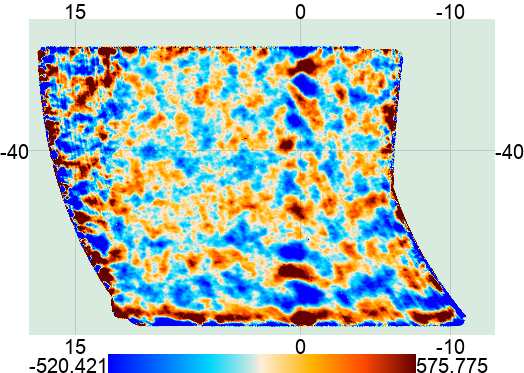

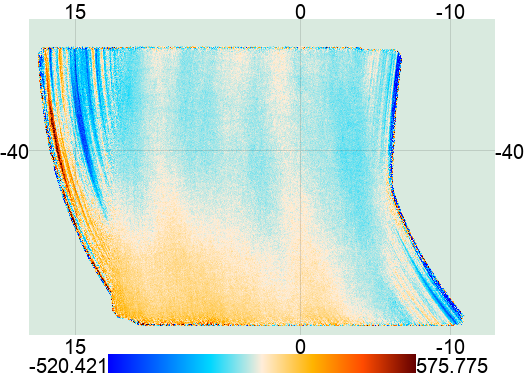

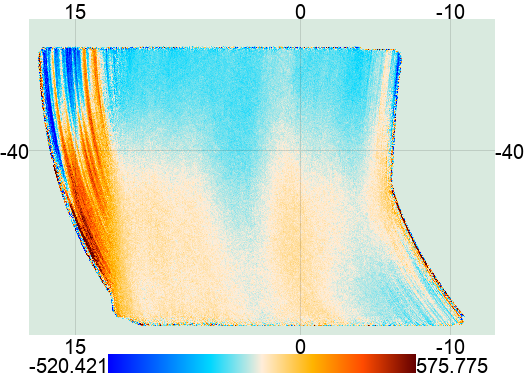

In [19]:
# We will select two maps of the same area, frequency, etc. one of which is source free
# and the other contains just the sources.  
fname_srcfree = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_map_srcfree.fits"
fname_src = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_srcs.fits"

# By combining the two maps chosen above we recover the observed sky with point sources
imap_srcfree = enmap.read_map(path + fname_srcfree)
imap_srcs =   enmap.read_map(path + fname_src)
imap = imap_srcfree + imap_srcs

# We can now plot the maps we just read in
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

eshow(imap, **{"downgrade": 8, "colorbar": True, "ticks": 25})

Note that in the above map we actually see three maps.  The first is the I (or T) map and the next two are Q and U respectively.  To access just the temperature map, or just the Q or U maps, one can use normal array indexing.  We can also use indexing or enmap's submap feature to view a smaller patch of the map.  

As before, submaps are referenced by defining a bounding box according to :
> box = [[dec_from, ra_from],[dec_to, ra_to]] $\quad$ (in radians)


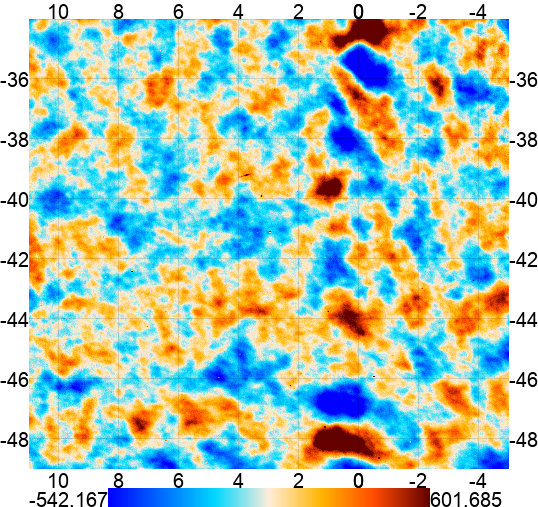

In [20]:
# Define a box to trim the map
box = np.array([[-49,11],[-34,-5]])*utils.degree

# Trim the maps using the submap feature
smap = imap.submap(box)

# Display just the intensity map using numpy array indexing (I = 0, Q = 1, U = 2)
eshow(smap[0], **{"downgrade": 4, "colorbar": True, "ticks": 2})


# Cross Spectra of patches 

Given that each patch has multiple splits we are able to calculate simple cross spectra of patches. 

In this example we will read in two different splits for the same patch, frequency etc.  We also choose to leave out the point sources.

The basic steps for this are:


1.   Read in the maps of interest
2.   Trim and apodize as needed to exclude noisy regions 
3.   Generate alms from the two patches
4.   Cross correlate to get the cls
5.   Adjust cls by accounting for the sky fraction (w2_new) and convert from cls to Dls




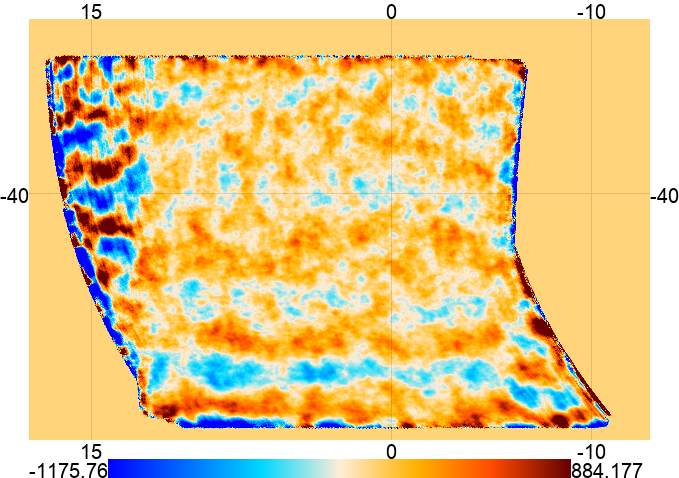

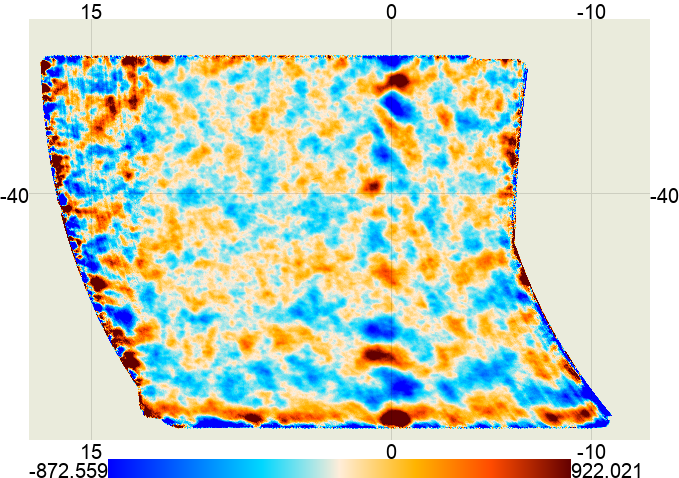

In [21]:
# We will read in another map of this same patch from earlier.  This time let's
# leave the point sources out   
fname_srcfree_1 = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set1_map_srcfree.fits"
fname_srcfree_2 = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_map_srcfree.fits"
fname_srcs = "act_dr4_s15_D8_pa2_f150_nohwp_night_3pass_4way_set2_srcs.fits"

# By combining the two maps chosen above we recover the observed sky with point sources
imap_srcfree_1 = enmap.read_map(path + fname_srcfree_1) 
imap_srcfree_2 = enmap.read_map(path + fname_srcfree_2) 

# We can now plot the maps we just read in
eshow(imap_srcfree_1[0], **{"downgrade": 6, "colorbar": True, "ticks": 25})
eshow(imap_srcfree_2[0], **{"downgrade": 6, "colorbar": True, "ticks": 25})

We can trim and apodize these patches again

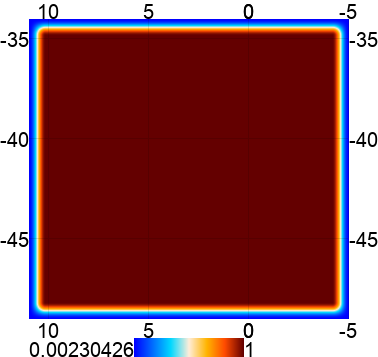

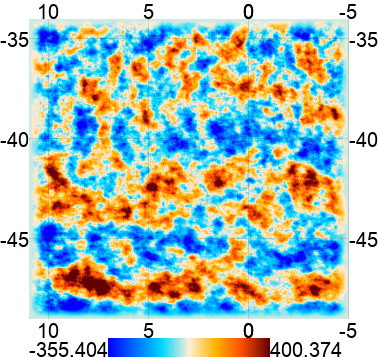

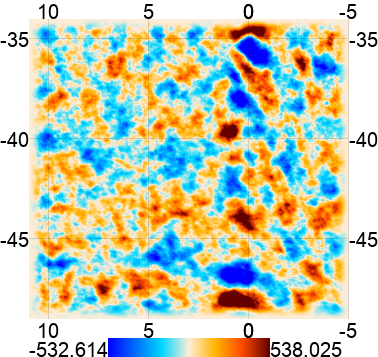

In [22]:
box = np.array([[-49,11],[-34,-5]])*utils.degree
smap_1 = imap_srcfree_1.submap(box)[0]
smap_2 = imap_srcfree_2.submap(box)[0]

# Define taper using enmap.apod and then plot
apod_pix = 100
taper    = enmap.apod(smap_1*0+1,apod_pix) #Ensures the taper map has the same shape and wcs as the data

eshow(taper,  **{"downgrade": 6, "colorbar": True, "ticks": 5})
eshow(smap_1*taper, **{"downgrade": 6, "colorbar": True, "ticks": 5})
eshow(smap_2*taper, **{"downgrade": 6, "colorbar": True, "ticks": 5})

Now we cross correlating these in just as we did with the Planck x ACT example above

In [23]:
# First we get the alms
alms_1 = np.cdouble(curvedsky.map2alm(smap_1*taper, lmax = 6000))
alms_2 = np.cdouble(curvedsky.map2alm(smap_2*taper, lmax = 6000))

# Next step we get the cls using healpy
cls = hp.alm2cl(alms_1, alms_2)

# We also want the corresponding ells which we can get easily
ell = np.arange(len(cls))

# Now we calculate the weighting we have to apply to our spectrum due to the 
# trimmed size
w2 = enmap.area(smap_1.shape, smap_1.wcs) / 4. / np.pi

# Now we combine these to get the Dls
Dl = cls*ell **2 / w2 

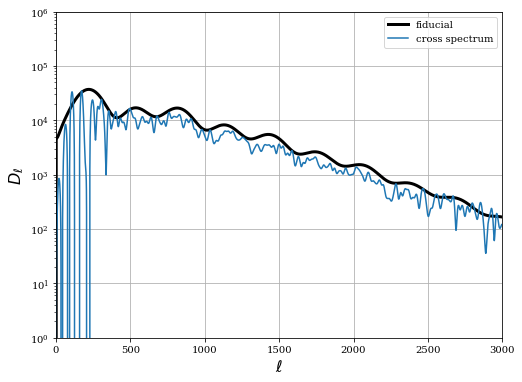

In [24]:
# Read in a camb fiducial spectrum for comparison
from pixell import powspec
camb_theory = powspec.read_spectrum(path + "camb_theory.dat")
cltt = camb_theory[0,0,:3000]
ls = np.arange(cltt.size)

# Now we can plot our power spectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.grid(True)

# Plot cross and camb
plt.plot(ls, cltt*ls**2., lw=3,color='k', label = "fiducial")
plt.plot(ell, Dl, label = "cross spectrum")
plt.legend()
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 16)
plt.ylabel('$D_{\\ell}$', fontsize = 16)
plt.ylim(1 ,1e6)
plt.xlim(0, 3000)
plt.show()

This looks reasonably good now!  We can see the acoustic oscilations in the power spectrum and it seems to match our fiducial plot reasonably well.  

While this method works really well for quick power spectrum tests and for some analyses, we should still note its limitations.  We haven't taken into account the fact that the mask we applied by trimming the map has second order effects on the power spectrum and will actually couple modes.  For that reason, as mentioned above, more in-depth power spectrum analysis should use mask deconvolution algroithms such as **namaster**, **pitas** or **pspy**.

# Beams


As part of DR4 beam information is readily available and should be used when doing power spectrum analysis.  Here we demonstrate how to access these beams and generate window functions by squaring and normalizing them.

In [25]:
# Load the data
beam_fname = path + "s15_pa2_f150_nohwp_night_beam_tform_instant_cmbspec.txt"
data = np.loadtxt(beam_fname).T
ell, Bell = data[:2,:12001]

# Convert to window funciton
Well = Bell**2

# Apply normalization
norm = Well[0]
Well /= norm

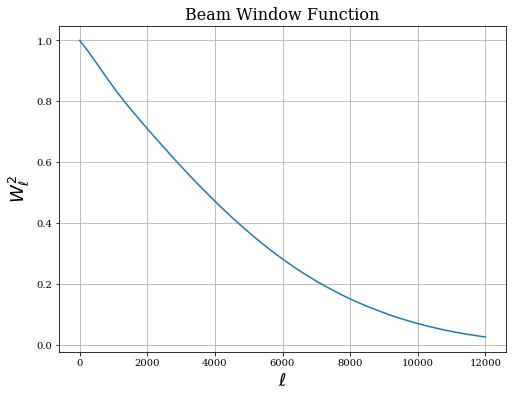

In [26]:
# Now we can plot the normalized beam window function
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ell, Well)

plt.title("Beam Window Function", fontsize = 16)
plt.xlabel('$\\ell$', fontsize = 18)
plt.ylabel('$W_{\\ell}^2$', fontsize = 18)
plt.grid(True)
plt.show()

### Continue to the next section

[Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations 